In [1]:
import wandb
import sys
sys.path.append('../src/')
from model import AEDist
from omegaconf import OmegaConf
from geodesic import ODEFunc, GeodesicODE
import os
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import scprep
import matplotlib.pyplot as plt

In [2]:
wandb.login()
api = wandb.Api()
entity = "xingzhis"
project = "dmae"
# run_id = 'iio2bb24'
run_id = 'peh9k8ft'
run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
data_path2 = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path2, allow_pickle=True)
model = AEDist.load_from_checkpoint(ckpt_path)
x_tensor = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
# x_tensor_normalized = model.normalize(x_tensor)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [3]:
with torch.no_grad():
    z = model.encode(x_tensor)

In [4]:
# Swiss roll random integer
npts = len(z)
np.random.seed(231)
start = np.random.randint(0,npts,size=1)
starttwo = np.random.randint(0,npts,size=1)
startthree = np.random.randint(0,npts,size=1)
startfour = np.random.randint(0,npts,size=1)
startfive= np.random.randint(0,npts,size=1)
end = np.random.randint(0,npts,size=1)
#Select start and end points for NeuralODE

x0 = torch.tensor(z[start,:]).cpu() #Start point
x1 = torch.tensor(z[starttwo,:]).cpu() 
x2 = torch.tensor(z[startthree,:]).cpu() 
x3 = torch.tensor(z[startfour,:]).cpu() 
x4 = torch.tensor(z[startfive,:]).cpu() 
xfin = torch.tensor(z[end,:]).cpu() 
xbatch = torch.cat((x0,x1,x2,x3,x4),0)
endbtch = torch.cat((xfin,xfin,xfin,xfin,xfin),0)


print(xfin.shape)
print(xbatch.shape)
print(endbtch.shape)

torch.Size([1, 2])
torch.Size([5, 2])
torch.Size([5, 2])


/tmp/tmp.syVyBOCapi/ipykernel_1909859/4291246267.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(z[start,:]).cpu() #Start point
/tmp/tmp.syVyBOCapi/ipykernel_1909859/4291246267.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(z[starttwo,:]).cpu()
/tmp/tmp.syVyBOCapi/ipykernel_1909859/4291246267.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(z[startthree,:]).cpu()
/tmp/tmp.syVyBOCapi/ipykernel_1909859/4291246267.py:14: UserWarning: To copy construct from a tensor, it is r

In [5]:
dataset = TensorDataset(xbatch, endbtch)
dataloader = DataLoader(dataset, batch_size=len(xbatch), shuffle=True)

In [6]:
odemodel = GeodesicODE(in_dim=2, hidden_dim=32, fcn=model.decoder, lr=1e-2, alpha=0.01, beta=0.01)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'fcn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['fcn'])`.
  rank_zero_warn(


In [7]:
odemodel.pretraining = True
pretrainer = pl.Trainer(max_epochs=200)
pretrainer.fit(odemodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: Pos

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [8]:
with torch.no_grad():
    zhat_no_len_reg = odemodel(xbatch)

<Axes: >

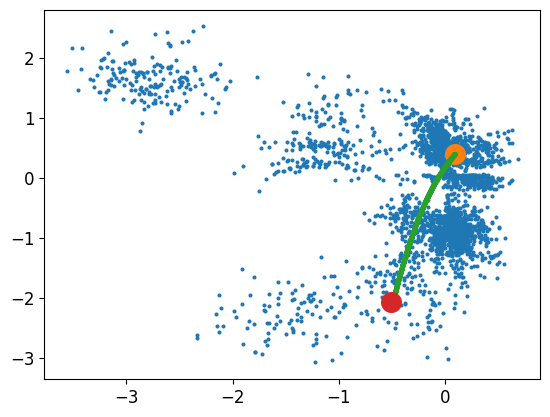

In [13]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(z.detach().cpu().numpy(), ax=ax)
# for i in range(zhat_no_len_reg.shape[1]):
for i in [1]:
    scprep.plot.scatter2d(xbatch[i].detach().cpu().numpy(), ax=ax)
    scprep.plot.scatter2d(zhat_no_len_reg[:,i,:].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(xfin[0].detach().cpu().numpy(), ax=ax)

In [10]:
odemodel.pretraining = False
odemodel.hparams.lr = 1e-3
odemodel.hparams.lam=100
pretrainer = pl.Trainer(max_epochs=200)
pretrainer.fit(odemodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: Pos

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [11]:
with torch.no_grad():
    zhat = odemodel(xbatch)

<Axes: >

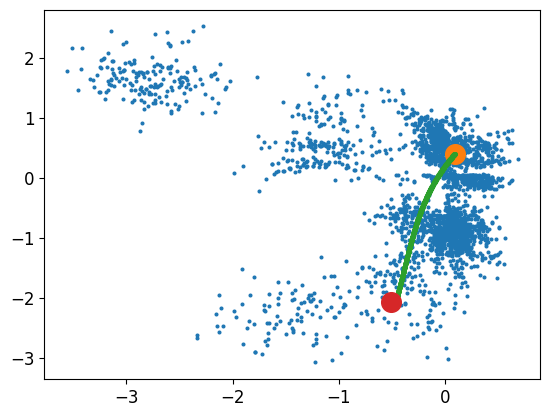

In [14]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(z.detach().cpu().numpy(), ax=ax)
# for i in range(zhat.shape[1]):
for i in [1]:
    scprep.plot.scatter2d(xbatch[i].detach().cpu().numpy(), ax=ax)
    scprep.plot.scatter2d(zhat[:,i,:].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(xfin[0].detach().cpu().numpy(), ax=ax)